In [92]:
#This code uses Topspin pulse program: cpmg. In order for this version of the code to run, experiment should be calibrated
#with the same parameters that allow zg spectrum to be centerd on only doublet.

#It may be possible to change this code to analyze multiple doublets, but have to think more about how chemical shift evolution would affect this, and how to account for correct x axis with multiple peaks.

In [93]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import nmrglue as ng
import numpy as np
from scipy import integrate
from scipy.optimize import curve_fit

import global_constants as glob

#%matplotlib notebook # commented out cuz it causes my computer to not plot anything
# import pulsee.simulation as sim
# from statistics import median
plt.rcParams['figure.dpi'] = glob.DPI_DISPLAY

plt.rcParams['font.family'] = ['Helvetica']
""" This is to save plots as PDF with editable text (so that Adobe illustrator recognizes text) """
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42



# Helper Functions

In [94]:
def combine_to_magnitude(real, imag):
    assert len(real) == len(imag)
    return np.sqrt(real ** 2 + imag ** 2)


def get_folder_path(f_n):
    return fr"{Bruker_folders_path}\{f_n}\pdata\1"

# Inversion Recovery
def t1_func(tau, a, t1):
    return a * (1 - 2 * np.exp(-tau / t1))

def t2_func(x, t2, a, b, k, offset):
    return a * np.exp(-x / t2) + b * np.sin(k * x) + offset


def t2_func_exp(x, T2, A, omega, Tj, C, offset1, offset2):
    return (A * np.cos(omega * x + offset2) * np.exp(-x / Tj) + C) * np.exp(-x / T2) + offset1

# Importing Data
#### Select Filepath to CPMG Experiment

In [95]:
# Bruker_folders_path = r"C:\Users\donny\Desktop\desktop_files\Brown\All_data\All_data_after_7_25\Sample132_05_07_2024"
Bruker_folders_path = r"C:\Users\donny\Desktop\desktop_files\Brown\All_data\pycharm_data\2024_12_23\T2"

In [96]:
folder_nums = os.listdir(f"{Bruker_folders_path}")
folder_nums_sorted = sorted(folder_nums, key=lambda x: int(''.join(filter(str.isdigit, x))))
print(folder_nums_sorted)
folder_name = folder_nums_sorted[1]
#folder_nums = [str(s) for s in (sorted([int(x) for x in folder_nums]))] # ordering by increasing number value
print(folder_name)

['189', '190', '191']
190


In [97]:
get_folder_path(folder_name)

'C:\\Users\\donny\\Desktop\\desktop_files\\Brown\\All_data\\pycharm_data\\2024_12_23\\T2\\190\\pdata\\1'

In [98]:
# all_components=True to get both the real & imaginary spectra
all_data = ng.bruker.read_pdata(get_folder_path(folder_name), all_components=True)[1]
all_data = np.array(all_data)
print(all_data.shape)
#this step will not work without "XF2" which makes 2ii file from 2rr
print(
    'Output of this cell should look something like "(2, 1024, 32768)". If it is only 2 numbers long you need to open the Topspin file and run "XF2".')

(2, 1024, 32768)
Output of this cell should look something like "(2, 1024, 32768)". If it is only 2 numbers long you need to open the Topspin file and run "XF2".


# Define Parameters Needed for Calculation

In [99]:
SIZE_OF_FID = 44
VD_START = 0
VD_END = .245
VD_STEP_SIZE = 0.005
VDS = np.linspace(VD_START, VD_END, SIZE_OF_FID)  # inclusive of start & end

PULSE_DURATION_90 = 16.6E-6  # (s)
PULSE_DURATION_180 = 33.1E-6  # (s)
# d20 = 1.25E-3  # (s) [d20-180-d20] loop
SPECTRUM_WIDTH = 2000  # Hz #for F2 I believe
J = 22.0005  # Hz
#ns 8

# DO NOT NEED FOR CALCULATION
#B_0 = 9  # Tesla
#SPECTRUM_OFFSET = 49697.66
#w_1_Bruker = 242950699.7  # Hz
#w_2_Bruker = 242951648.8  # Hz
#TEMP = 310  # Kelvin
#BF1 = 161.9755930

### Plot Bruker Spectrum Data

In [100]:
all_data = np.flip(all_data, axis=2)  #Flip the frequency axis
# Cut off all zero data point
all_data = all_data[:, :SIZE_OF_FID, :]  #(-1 python starts at index zero)


# data_mag = combine_to_magnitude(all_data[0], all_data[1])
data_mag = all_data[0]  # wrong name! but keeping it for now
print(all_data.shape, data_mag.shape)

(2, 44, 32768) (44, 32768)


In [101]:
#2nd method
# #Auto Phase Data
# complex_data = np.array(all_data[0] + 1j * all_data[1])
# fixed=ng.process.proc_autophase.autops(complex_data, "acme", p0=0.0, p1=0.0)
# real_part = np.real(fixed)
# imaginary_part = np.imag(fixed)

# tt=np.sqrt(real_part**2 + imaginary_part**2)
# tt.shape
# plt.plot(tt[8])

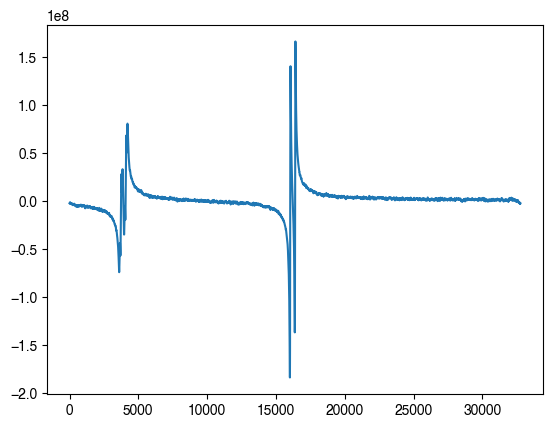

In [102]:
plt.plot(data_mag[0])
#plt.plot(data_mag[round(SIZE_OF_FID / 8)])
#plt.plot(data_mag[round(SIZE_OF_FID / 2)])
#plt.plot(data_mag[SIZE_OF_FID - 1])

# Calculating the frequency axis for the spectrum
According to Bruker's software, the middle of the spectrum should be the experimental larmor frequency (with chemical shift included), and we can set this to 0 Hz. In other words, the frequency axis range is: (-spectrum_width/2, spectrum/2), with 0 in the middle, and left peak should occur at -$J$ and right peak at $J$

In [103]:
freqs = np.linspace(-SPECTRUM_WIDTH / 2, SPECTRUM_WIDTH / 2, data_mag.shape[1])
L_FREQ = 0
R_FREQ = -J

(-50.0, 50.0)

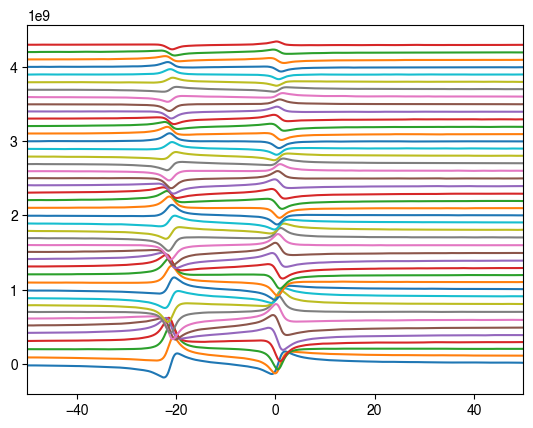

In [104]:
I_RANDOM = 0
fig, ax = plt.subplots()
Y_OFFSET = 1E8

for i in range(SIZE_OF_FID):
    ax.plot(freqs, data_mag[i] + Y_OFFSET * i)
ax.set_xlim(-50, 50)

# Plotting a Few Spectra

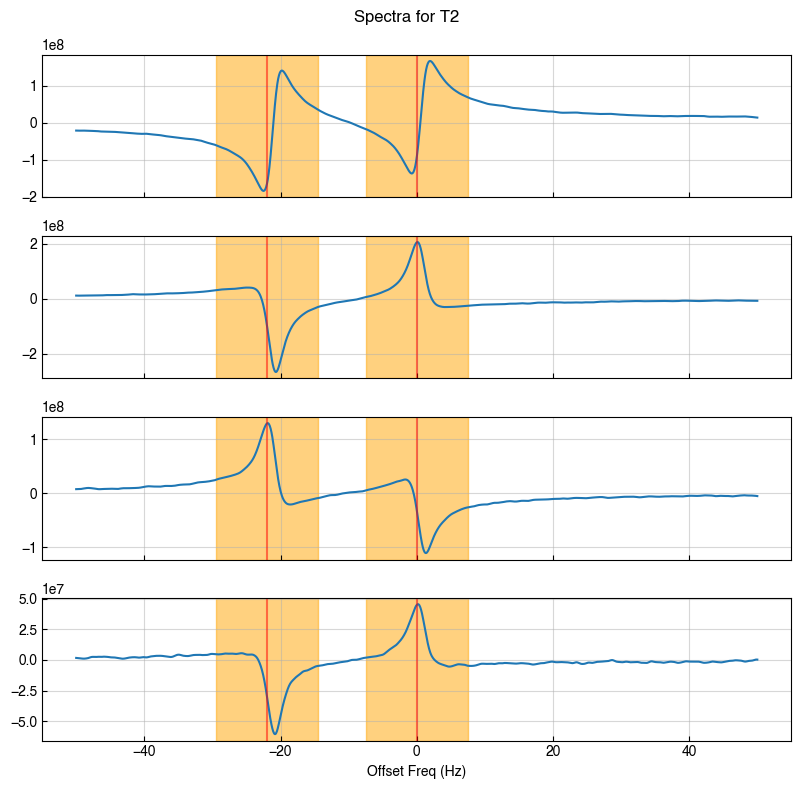

In [105]:
DISPLAY_INDICES = [0, round(SIZE_OF_FID / 8), round(SIZE_OF_FID / 2),
                   SIZE_OF_FID - 1]  #Python starts couting at 0, while Bruker starts counting at zero hence the "-1"
N_DISPLAY = len(DISPLAY_INDICES)

INTGR_WIDTH = 15  # in Hz. The width to integrate over.
X_LIMS_DISPLAY = [-50, 50]
i_L = np.absolute(freqs - X_LIMS_DISPLAY[0]).argmin()
i_R = np.absolute(freqs - X_LIMS_DISPLAY[1]).argmin()

fig, axs = plt.subplots(N_DISPLAY, 1, figsize=(2 * N_DISPLAY, 8), sharex=True, sharey=False)

# Making an offset so the red lines visually line up with the peaks
intgr_offset = 0
intgr_centers = (L_FREQ + intgr_offset, R_FREQ + intgr_offset)

for i_axis, i_spectrum in enumerate(DISPLAY_INDICES):
    # plot the spectrum
    ax = axs[i_axis]
    ax.plot(freqs[i_L: i_R + 1], data_mag[i_spectrum][i_L: i_R + 1])
    ax.grid(alpha=0.5)
    ax.set(xlabel='Offset Freq (Hz)')
    ax.label_outer()
    ax.tick_params(direction='in')

    # red centers
    ax.axvline(intgr_centers[0], color='r', alpha=0.5)
    ax.axvline(intgr_centers[1], color='r', alpha=0.5)
    # orange integration window
    ax.axvspan(intgr_centers[0] - INTGR_WIDTH / 2, intgr_centers[0] + INTGR_WIDTH / 2, color='orange', alpha=0.5)
    ax.axvspan(intgr_centers[1] - INTGR_WIDTH / 2, intgr_centers[1] + INTGR_WIDTH / 2, color='orange', alpha=0.5)

    # plot integration lines

fig.suptitle('Spectra_Theory for T2')
fig.tight_layout()
plt.show()

# Integrate each spectrum to get the peak intensities
1. Integrate sample points using (`scipy.integrate.trapezoid`)
2. Integrate sample points using (`scipy.integrate.simpson`)

In [106]:
def integrate_doublet(spectrum):
    i_L_lo = np.abs(freqs - (intgr_centers[0] - INTGR_WIDTH / 2)).argmin()
    i_L_hi = np.abs(freqs - (intgr_centers[0] + INTGR_WIDTH / 2)).argmin()
    i_R_lo = np.abs(freqs - (intgr_centers[1] - INTGR_WIDTH / 2)).argmin()
    i_R_hi = np.abs(freqs - (intgr_centers[1] + INTGR_WIDTH / 2)).argmin()

    area_L = integrate.trapezoid(spectrum[i_L_lo: i_L_hi])
    area_R = integrate.trapezoid(spectrum[i_R_lo: i_R_hi])
    return area_L, area_R

In [107]:
areas_all = [integrate_doublet(spectrum) for spectrum in data_mag]
areas_all = np.array(areas_all)
areas_all.shape

(44, 2)

In [108]:
areas_left = areas_all[:, 0]
areas_right = areas_all[:, 1]

# Simple Plot and Fit

In [109]:
wait_times = []

for vd in VDS:
    time = PULSE_DURATION_90 + vd + PULSE_DURATION_180 + vd + PULSE_DURATION_180
    #time = PULSE_DURATION_180 + vd + PULSE_DURATION_90
    wait_times.append(time)

wait_times = np.array(wait_times)
wait_times

#should start time start at beginning, middle, or end of first pulse?

array([8.28000000e-05, 1.14781488e-02, 2.28734977e-02, 3.42688465e-02,
       4.56641953e-02, 5.70595442e-02, 6.84548930e-02, 7.98502419e-02,
       9.12455907e-02, 1.02640940e-01, 1.14036288e-01, 1.25431637e-01,
       1.36826986e-01, 1.48222335e-01, 1.59617684e-01, 1.71013033e-01,
       1.82408381e-01, 1.93803730e-01, 2.05199079e-01, 2.16594428e-01,
       2.27989777e-01, 2.39385126e-01, 2.50780474e-01, 2.62175823e-01,
       2.73571172e-01, 2.84966521e-01, 2.96361870e-01, 3.07757219e-01,
       3.19152567e-01, 3.30547916e-01, 3.41943265e-01, 3.53338614e-01,
       3.64733963e-01, 3.76129312e-01, 3.87524660e-01, 3.98920009e-01,
       4.10315358e-01, 4.21710707e-01, 4.33106056e-01, 4.44501405e-01,
       4.55896753e-01, 4.67292102e-01, 4.78687451e-01, 4.90082800e-01])

In [110]:
guesses = [ 2.15596580e-01,  2.14270367e+10,  6.00267028e+01,  2.05186193e+11,
        1.84219662e+08, -1.32915336e+07,  4.48370558e-01]

# T2, A, omega, Tj, C, offset1, offset2
#(A * np.cos(omega * x + offset2) * np.exp(-x / Tj) + C) * np.exp(-x / T2) + offset1

lower_bounds = [0, 0, 0, 0, -1e12, -1e12,-2*np.pi]
upper_bounds = [1, 1e12, 1e12, 1e12, 1e12, 1e12,2*np.pi]

popt_left, pcov_left = curve_fit(t2_func_exp, wait_times, areas_left, p0=guesses, bounds=(lower_bounds, upper_bounds))
popt_right, pcov_right = curve_fit(t2_func_exp, wait_times, areas_right, p0=guesses, bounds=(lower_bounds, upper_bounds))

t2_left, t2_left_err = popt_left[0], np.sqrt(pcov_left[0,0])
t2_right, t2_right_err = popt_right[0], np.sqrt(pcov_right[0,0])

PLUS_MINUS = u'\u00b1'
display(popt_left)
display(popt_right)
print(f"Left peak: T2 = {t2_left: .3f} {PLUS_MINUS} {t2_left_err:.3f}")
print(f"Right peak: T2 = {t2_right: .3f} {PLUS_MINUS} {t2_right_err:.3f}")

array([ 2.00024724e-01,  1.54684204e+10,  6.21624904e+01,  5.12965483e+08,
       -1.09896987e+09,  1.60844007e+08,  9.81075091e-01])

array([ 8.91580338e-02,  3.61126239e+09,  5.10640158e+01,  4.09346438e+11,
        3.02657548e+08,  2.20268174e+07, -5.20103424e-01])

Left peak: T2 =  0.200 ± 0.037
Right peak: T2 =  0.089 ± 0.329


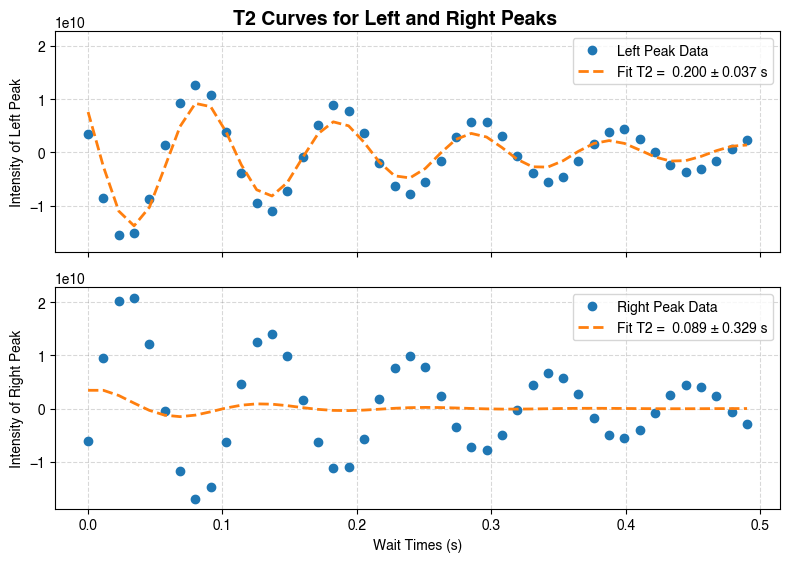

In [111]:
# Create the figure and axis with adjusted layout for publication
fig_t2, axs_t2 = plt.subplots(2, 1, figsize=(8, 6), sharex=True, sharey=True)

# Plot data points with a distinct color and marker size for clarity
axs_t2[0].plot(wait_times, areas_left, 'o', markersize=6, label='Left Peak Data')
axs_t2[1].plot(wait_times, areas_right, 'o', markersize=6, label='Right Peak Data')

# Plot fit lines with higher contrast against the data points
axs_t2[0].plot(wait_times, t2_func_exp(wait_times, *popt_left), linestyle='--', linewidth=2,
               label=f"Fit T2 = {t2_left: .3f} {PLUS_MINUS} {t2_left_err:.3f} s")
axs_t2[1].plot(wait_times, t2_func_exp(wait_times, *popt_right), linestyle='--', linewidth=2,
               label=f"Fit T2 = {t2_right: .3f} {PLUS_MINUS} {t2_right_err:.3f} s")

# Set labels and increase font size for publication readability
axs_t2[0].set_ylabel("Intensity of Left Peak")
axs_t2[1].set_ylabel("Intensity of Right Peak")
axs_t2[1].set_xlabel("Wait Times (s)")

# Set legend positions and adjust font size
axs_t2[0].legend()
axs_t2[1].legend()

# Set title and adjust spacing
fig_t2.suptitle('T2 Curves for Left and Right Peaks', fontsize=14, weight='bold', y=0.93)

# Enable grid with a subtle color and style
[ax.grid(color='gray', linestyle='--', alpha=0.3) for ax in axs_t2]

# Optimize layout for spacing and readability
# fig_t2.tight_layout(pad=2.0)
fig_t2.tight_layout()

# Show the plot
plt.show()


In [112]:
print(popt_left[2]/(2*np.pi))
print(popt_right[2]/(2*np.pi))
print(popt_left[2])
print(popt_right[2])

9.893467627455658
8.12709052922963
62.16249043388627
51.06401580337398


In [113]:
pcov_left

array([[ 1.37350054e-03, -5.37700336e+07,  1.82834452e-03,
         5.05759218e-01, -6.94139949e+06,  3.60754108e+06,
        -3.40537658e-04],
       [-5.37700336e+07,  3.82906111e+18, -1.58167060e+08,
        -3.59311148e+10,  5.75049247e+17, -2.18316509e+17,
         2.79277516e+07],
       [ 1.82834452e-03, -1.58167060e+08,  7.75186924e-01,
         7.99644620e-01, -3.09570561e+08,  6.86719364e+07,
        -6.96982049e-02],
       [ 5.05759218e-01, -3.59311148e+10,  7.99644620e-01,
         3.57055273e+02,  1.73031076e+09, -8.78182886e+08,
        -1.25416066e-01],
       [-6.94139949e+06,  5.75049247e+17, -3.09570561e+08,
         1.73031076e+09,  2.72499280e+18, -9.95755600e+17,
         5.92830353e+07],
       [ 3.60754108e+06, -2.18316509e+17,  6.86719364e+07,
        -8.78182886e+08, -9.95755600e+17,  5.30500555e+17,
        -1.54964699e+07],
       [-3.40537658e-04,  2.79277516e+07, -6.96982049e-02,
        -1.25416066e-01,  5.92830353e+07, -1.54964699e+07,
         1.2657751

In [114]:
print(np.sqrt(pcov_left[2,2]))
print(np.sqrt(pcov_right[2,2]))

0.8804470022365275
43.69408416415447


# Integrating the other doublet


In [115]:
DOUBLET_OFFSET = -768.5
L_FREQ_OTHER = -J / 2 + DOUBLET_OFFSET
R_FREQ_OTHER = J / 2 + DOUBLET_OFFSET

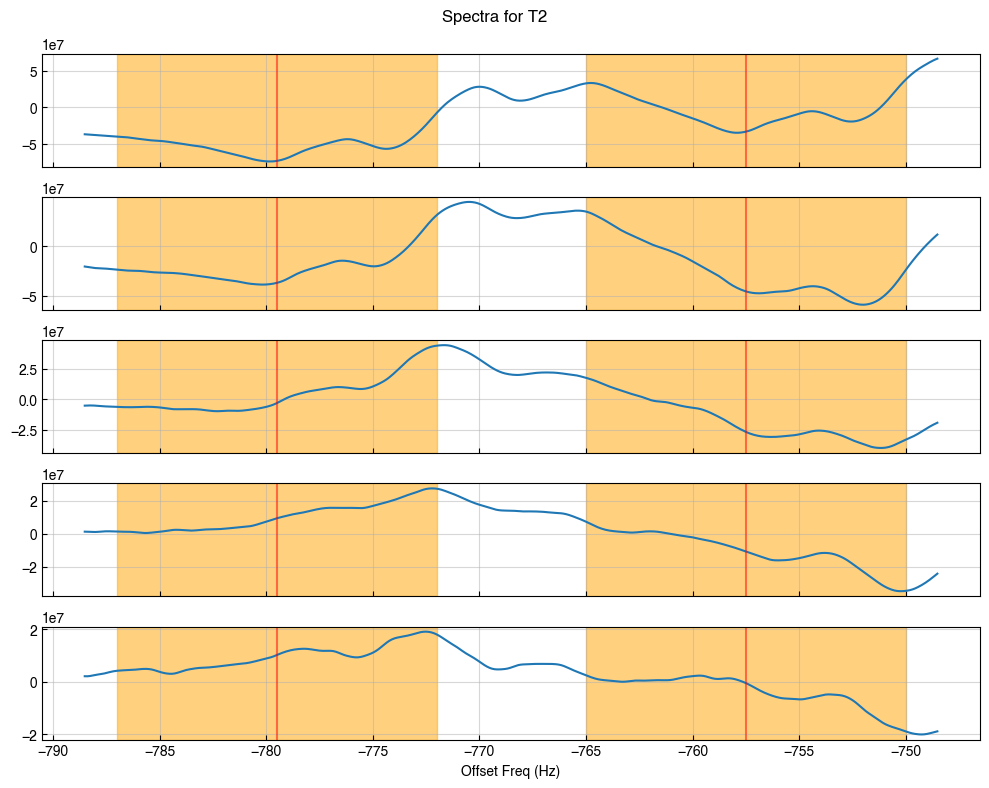

In [116]:
DISPLAY_INDICES = [0, 10, 20, 30, 40]  #Python starts couting at 0, while Bruker starts counting at zero hence the "-1"
N_DISPLAY = len(DISPLAY_INDICES)

INTGR_WIDTH = 15  # in Hz. The width to integrate over.
X_LIMS_DISPLAY = [-20 + DOUBLET_OFFSET, 20 + DOUBLET_OFFSET]
i_L = np.absolute(freqs - X_LIMS_DISPLAY[0]).argmin()
i_R = np.absolute(freqs - X_LIMS_DISPLAY[1]).argmin()

fig, axs = plt.subplots(N_DISPLAY, 1, figsize=(2 * N_DISPLAY, 8), sharex=True, sharey=False)

# Making an offset so the red lines visually line up with the peaks
intgr_offset = 0
intgr_centers = (L_FREQ_OTHER + intgr_offset, R_FREQ_OTHER + intgr_offset)

for i_axis, i_spectrum in enumerate(DISPLAY_INDICES):
    # plot the spectrum
    ax = axs[i_axis]
    ax.plot(freqs[i_L: i_R + 1], data_mag[i_spectrum][i_L: i_R + 1])
    ax.grid(alpha=0.5)
    ax.set(xlabel='Offset Freq (Hz)')
    ax.label_outer()
    ax.tick_params(direction='in')

    # red centers
    ax.axvline(intgr_centers[0], color='r', alpha=0.5)
    ax.axvline(intgr_centers[1], color='r', alpha=0.5)
    # orange integration window
    ax.axvspan(intgr_centers[0] - INTGR_WIDTH / 2, intgr_centers[0] + INTGR_WIDTH / 2, color='orange', alpha=0.5)
    ax.axvspan(intgr_centers[1] - INTGR_WIDTH / 2, intgr_centers[1] + INTGR_WIDTH / 2, color='orange', alpha=0.5)

    # plot integration lines

fig.suptitle('Spectra_Theory for T2')
fig.tight_layout()
plt.show()

In [117]:
def integrate_doublet(spectrum):
    i_L_lo = np.abs(freqs - (intgr_centers[0] - INTGR_WIDTH / 2)).argmin()
    i_L_hi = np.abs(freqs - (intgr_centers[0] + INTGR_WIDTH / 2)).argmin()
    i_R_lo = np.abs(freqs - (intgr_centers[1] - INTGR_WIDTH / 2)).argmin()
    i_R_hi = np.abs(freqs - (intgr_centers[1] + INTGR_WIDTH / 2)).argmin()

    area_L = integrate.trapezoid(spectrum[i_L_lo: i_L_hi])
    area_R = integrate.trapezoid(spectrum[i_R_lo: i_R_hi])
    return area_L, area_R

In [118]:
areas_all = [integrate_doublet(spectrum) for spectrum in data_mag]
areas_all = np.array(areas_all)
areas_all.shape

(44, 2)

In [119]:
areas_left = areas_all[:, 0]
areas_right = areas_all[:, 1]

In [120]:
guesses = [2e10, 1]
#a, t1
lower_bounds = [0, 0]
upper_bounds = [np.inf, 1e3]

popt_left, pcov_left = curve_fit(t1_func, wait_times, areas_left, p0=guesses, bounds=(lower_bounds, upper_bounds))
popt_right, pcov_right = curve_fit(t1_func, wait_times, areas_right, p0=guesses, bounds=(lower_bounds, upper_bounds))

t1_left, t1_left_err = popt_left[1], np.sqrt(pcov_left[1,1])
t1_right, t1_right_err = popt_right[1], np.sqrt(pcov_right[1,1])

PLUS_MINUS = u'\u00b1'
display(popt_left)
display(popt_right)
print(f"Left peak: T1 = {t1_left: .3f} {PLUS_MINUS} {t1_left_err:.3f}")
print(f"Right peak: T1 = {t1_right: .3f} {PLUS_MINUS} {t1_right_err:.3f}")

array([1.97593722e+07, 3.32299531e-04])

array([9.02961082e+08, 7.04720598e-02])

Left peak: T1 =  0.000 ± 0.266
Right peak: T1 =  0.070 ± 0.161


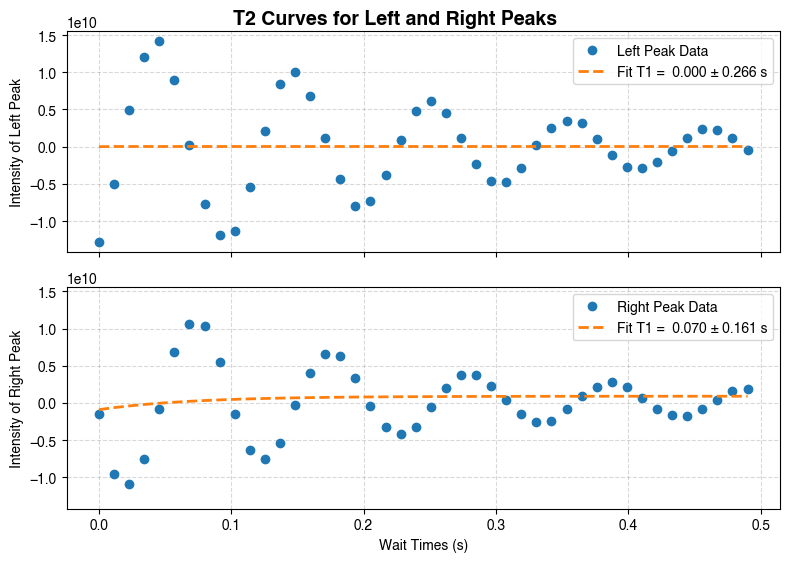

In [121]:
# Create the figure and axis with adjusted layout for publication
fig_t2, axs_t2 = plt.subplots(2, 1, figsize=(8, 6), sharex=True, sharey=True)

# Plot data points with a distinct color and marker size for clarity
axs_t2[0].plot(wait_times, areas_left, 'o', markersize=6, label='Left Peak Data')
axs_t2[1].plot(wait_times, areas_right, 'o', markersize=6, label='Right Peak Data')

# Plot fit lines with higher contrast against the data points
axs_t2[0].plot(wait_times, t1_func(wait_times, *popt_left), linestyle='--', linewidth=2,
               label=f"Fit T1 = {t1_left: .3f} {PLUS_MINUS} {t1_left_err:.3f} s")
axs_t2[1].plot(wait_times, t1_func(wait_times, *popt_right), linestyle='--', linewidth=2,
               label=f"Fit T1 = {t1_right: .3f} {PLUS_MINUS} {t1_right_err:.3f} s")

# Set labels and increase font size for publication readability
axs_t2[0].set_ylabel("Intensity of Left Peak")
axs_t2[1].set_ylabel("Intensity of Right Peak")
axs_t2[1].set_xlabel("Wait Times (s)")

# Set legend positions and adjust font size
axs_t2[0].legend()
axs_t2[1].legend()

# Set title and adjust spacing
fig_t2.suptitle('T2 Curves for Left and Right Peaks', fontsize=14, weight='bold', y=0.93)

# Enable grid with a subtle color and style
[ax.grid(color='gray', linestyle='--', alpha=0.3) for ax in axs_t2]

# Optimize layout for spacing and readability
# fig_t2.tight_layout(pad=2.0)
fig_t2.tight_layout()

# Show the plot
plt.show()
